###1. Business Understanding Goal: Enhance or automate the loan approval process using historical loan data, with two options:

Regression: Predict loan default risk score.

Classification: Predict loan approval directly.

Cost Asymmetry:

False approval (bad applicant): –$50,000

False rejection (good applicant): –$8,000

##Conclusion: Focus on classification (LoanApproved) and optimize for precision of bad ones, with emphasis on interpretable models (e.g., Logistic Regression, Decision Trees,).
    In this case, we need to focus on Accuracy since False Approvals are very costly

In [5]:
# Import libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn import set_config
set_config(display='diagram')

In [6]:
# Step 2: Load and Explore the Data
data = pd.read_csv("financial_loan_data.csv") 

In [7]:
# Examine the data via initial inspection 
print("First few rows of our dataset:")
print(data.head())
print("\nMissing values in each column:")
print(data.isnull().sum())
print("\nClassification:")
print(data['LoanApproved'].value_counts(normalize=True) * 100)

First few rows of our dataset:
   Age AnnualIncome  CreditScore EmploymentStatus EducationLevel  Experience  \
0   45   $39,948.00          617         Employed         Master          22   
1   38   $39,709.00          628         Employed      Associate          15   
2   47   $40,724.00          570         Employed       Bachelor          26   
3   58   $69,084.00          545         Employed    High School          34   
4   37  $103,264.00          594         Employed      Associate          17   

   LoanAmount  LoanDuration MaritalStatus  NumberOfDependents  ...  \
0       13152            48       Married                   2  ...   
1       26045            48        Single                   1  ...   
2       17627            36           NaN                   2  ...   
3       37898            96        Single                   1  ...   
4        9184            36       Married                   1  ...   

  MonthlyIncome  UtilityBillsPaymentHistory  JobTenure  NetWorth  \

In [8]:
# Quick overview
print(data.shape)
print(data.dtypes)
print(data.head())
print(data.isnull().sum())

(20000, 35)
Age                             int64
AnnualIncome                   object
CreditScore                     int64
EmploymentStatus               object
EducationLevel                 object
Experience                      int64
LoanAmount                      int64
LoanDuration                    int64
MaritalStatus                  object
NumberOfDependents              int64
HomeOwnershipStatus            object
MonthlyDebtPayments             int64
CreditCardUtilizationRate     float64
NumberOfOpenCreditLines         int64
NumberOfCreditInquiries         int64
DebtToIncomeRatio             float64
BankruptcyHistory              object
LoanPurpose                    object
PreviousLoanDefaults            int64
PaymentHistory                  int64
LengthOfCreditHistory           int64
SavingsAccountBalance         float64
CheckingAccountBalance          int64
TotalAssets                     int64
TotalLiabilities                int64
MonthlyIncome                 float64


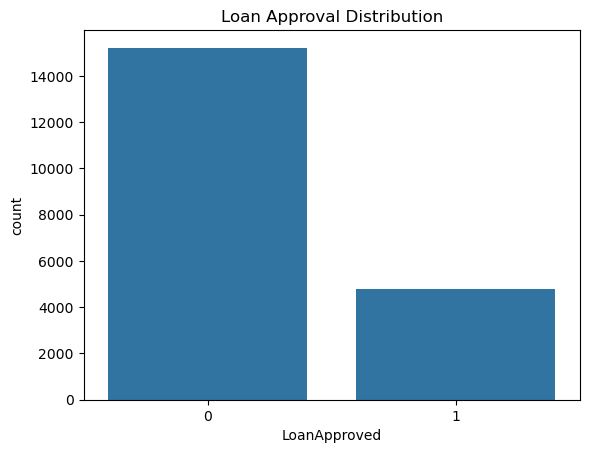

In [9]:
# Target distribution
sns.countplot(data=data, x='LoanApproved')
plt.title("Loan Approval Distribution")
plt.show()

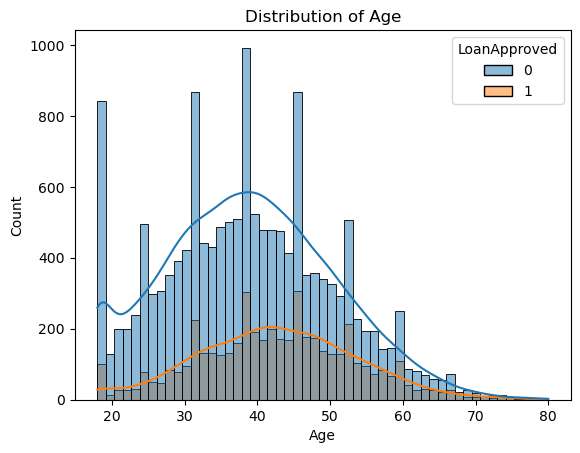

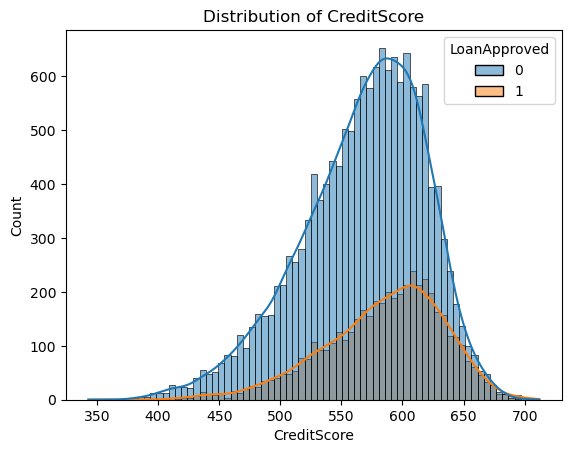

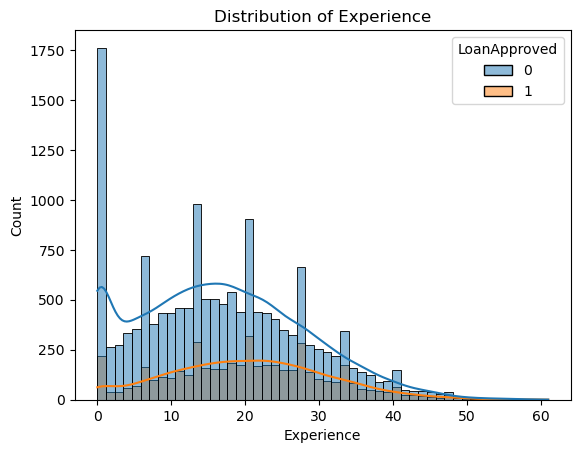

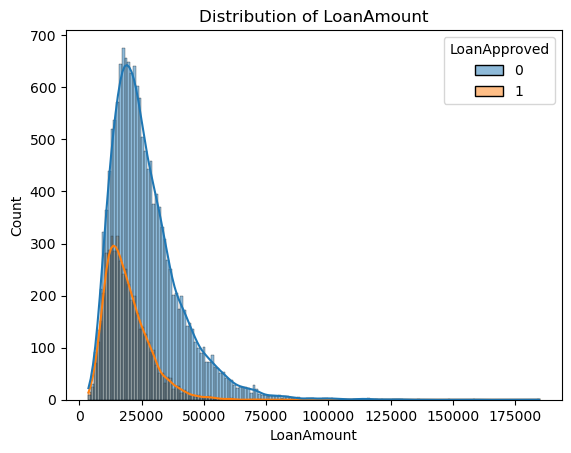

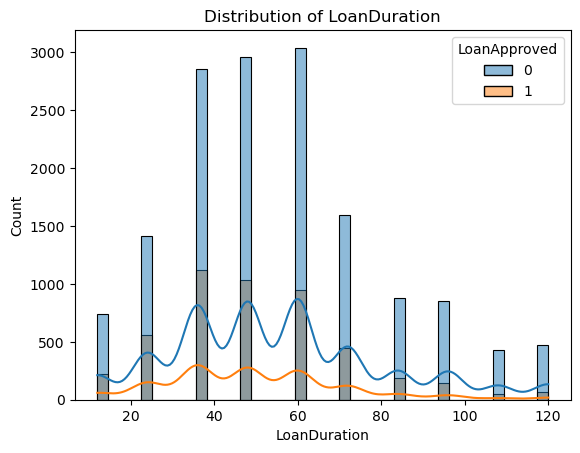

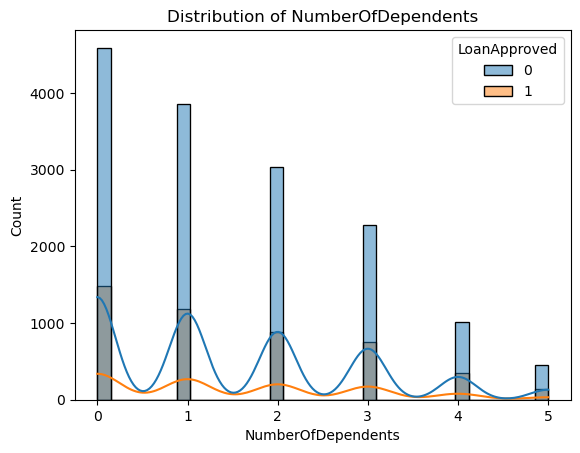

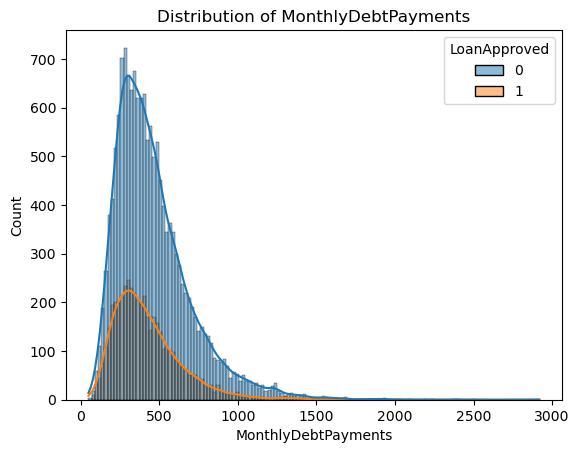

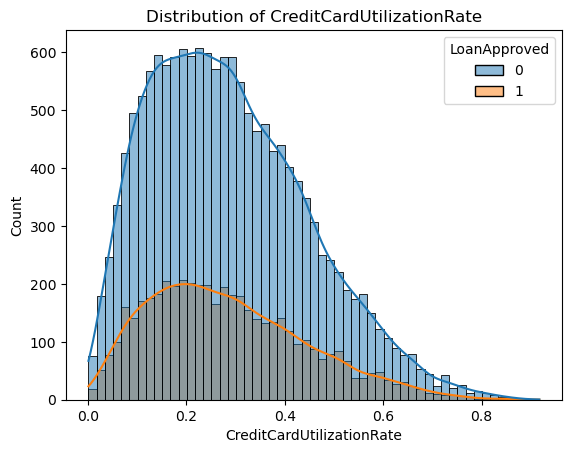

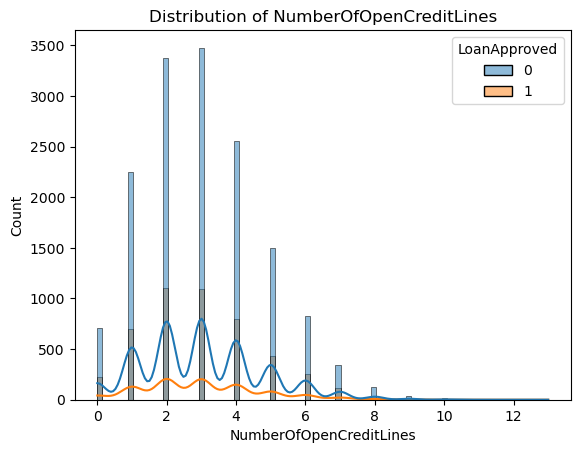

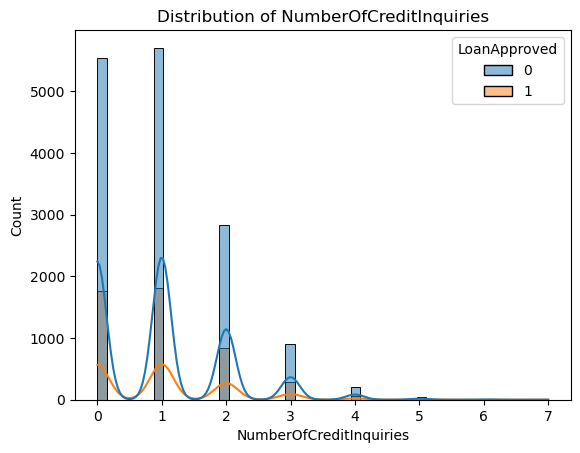

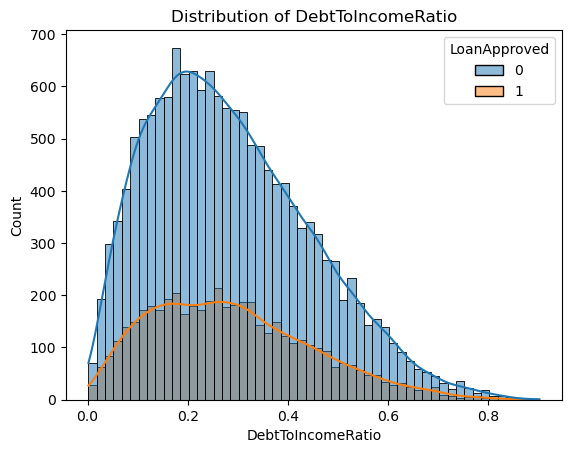

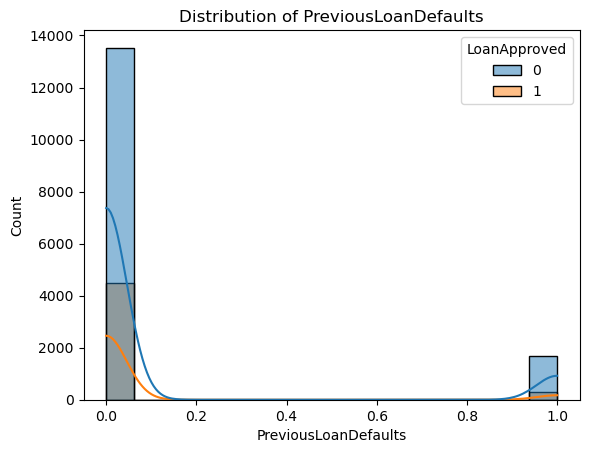

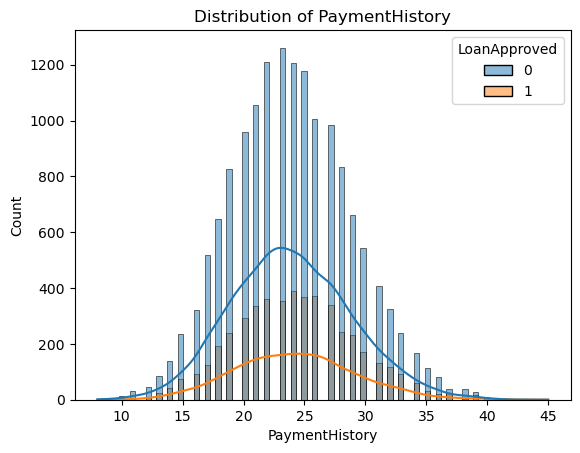

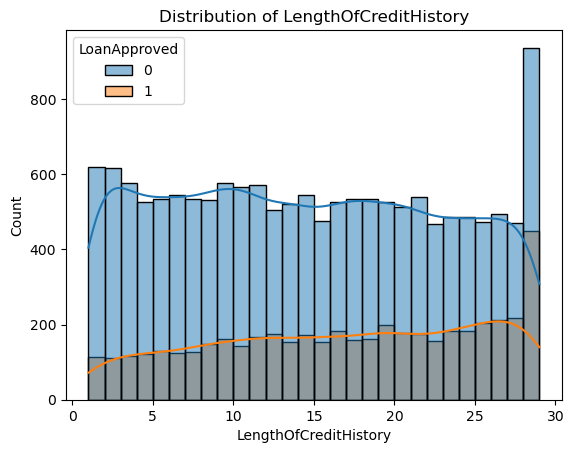

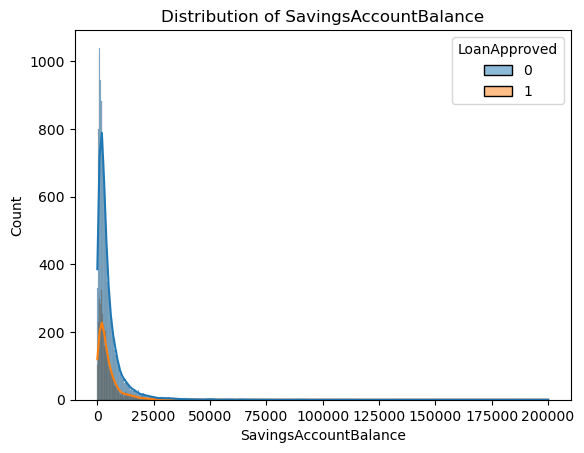

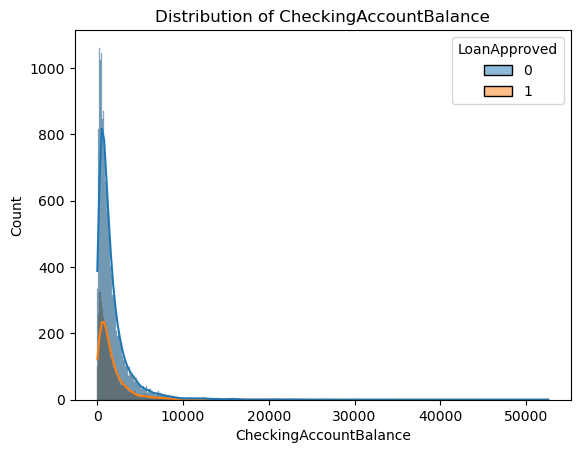

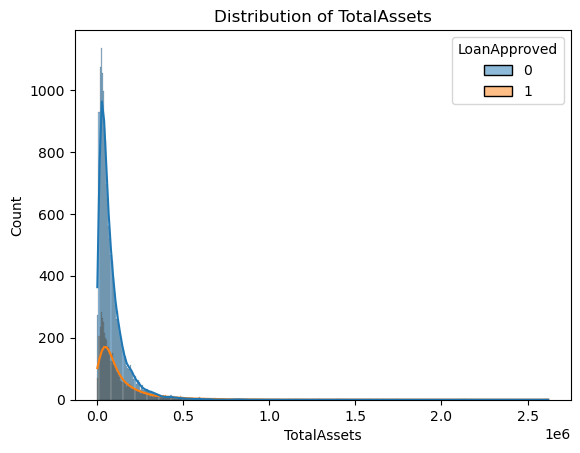

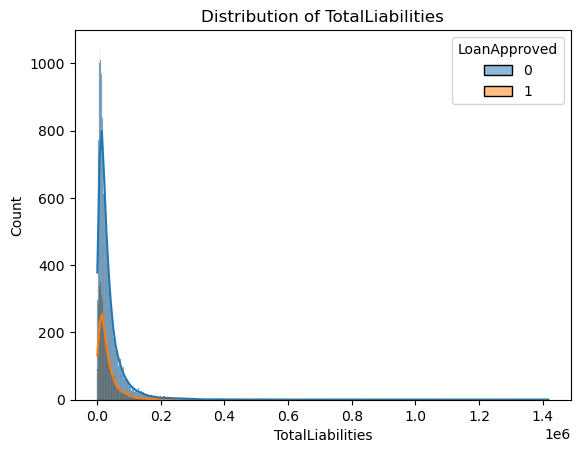

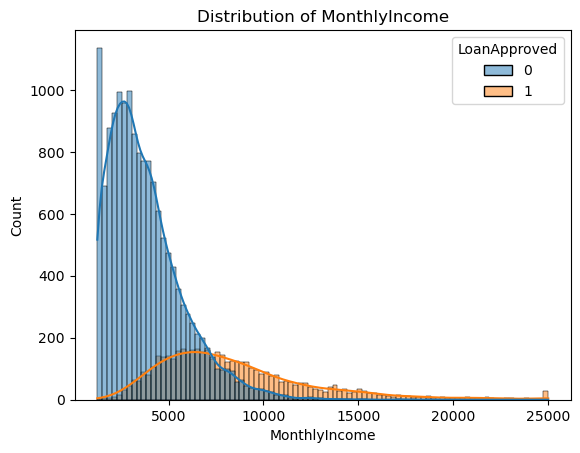

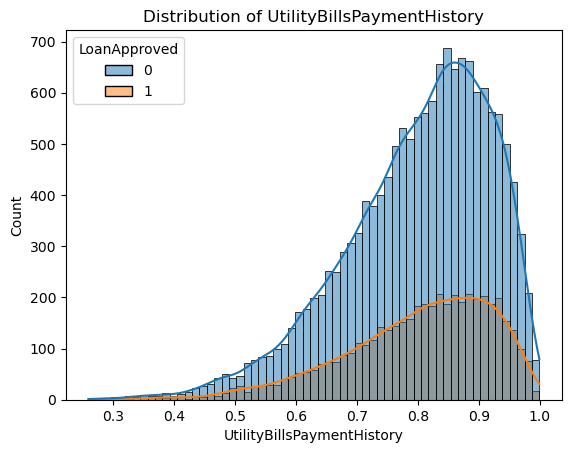

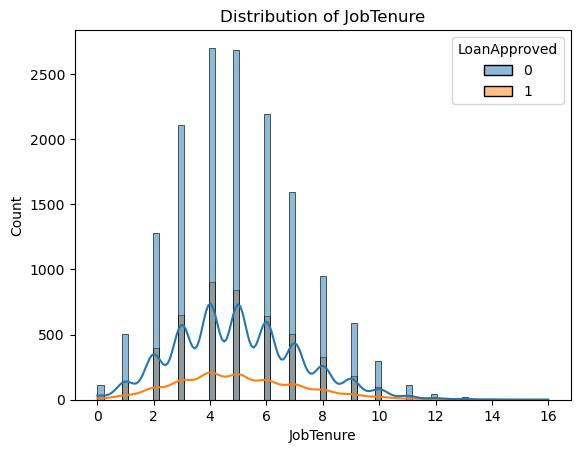

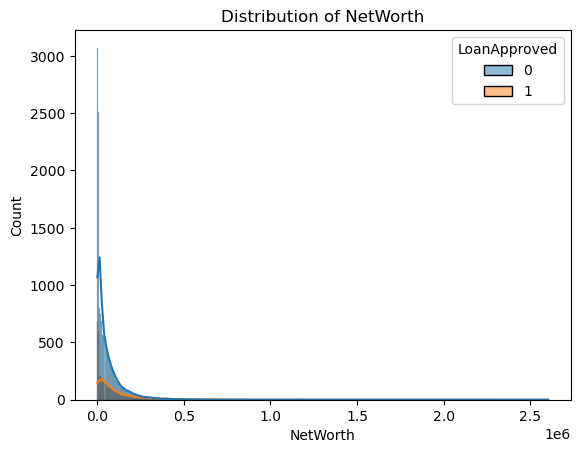

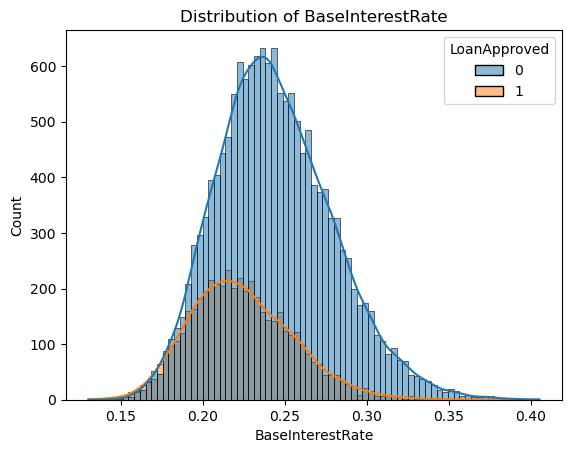

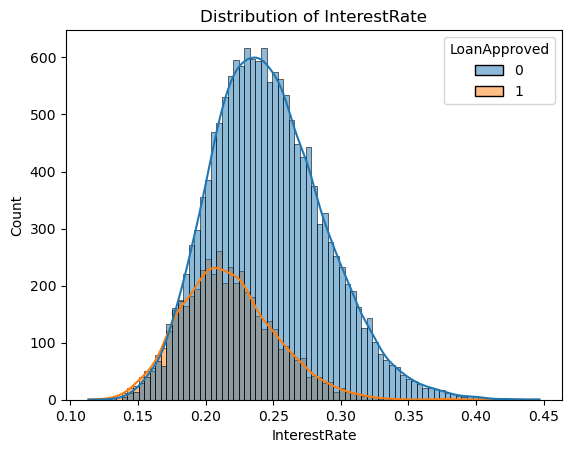

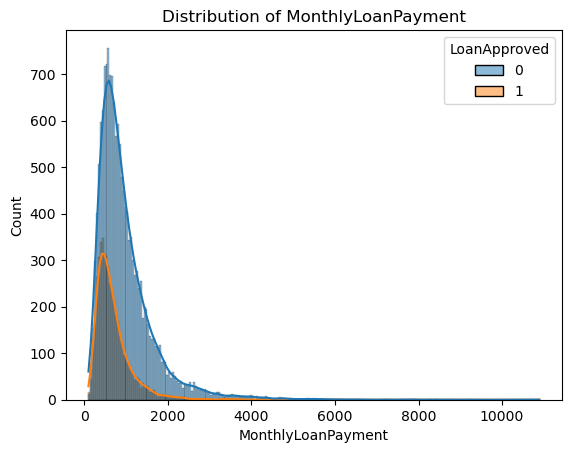

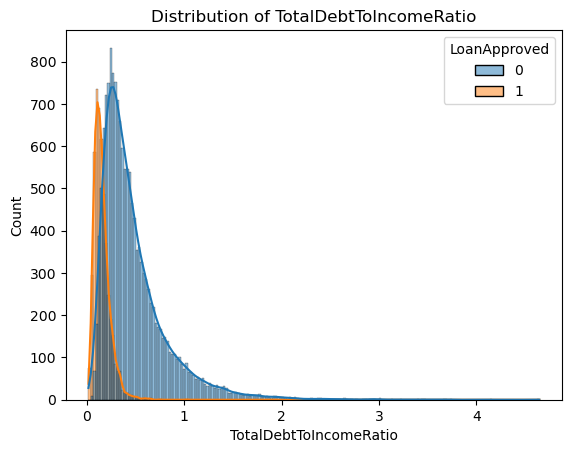

In [10]:
# Numerical feature distribution by target
numeric_cols = data.select_dtypes(include='number').columns.tolist()
for col in numeric_cols:
    if col not in ['LoanApproved', 'RiskScore']:
        sns.histplot(data, x=col, hue='LoanApproved', kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

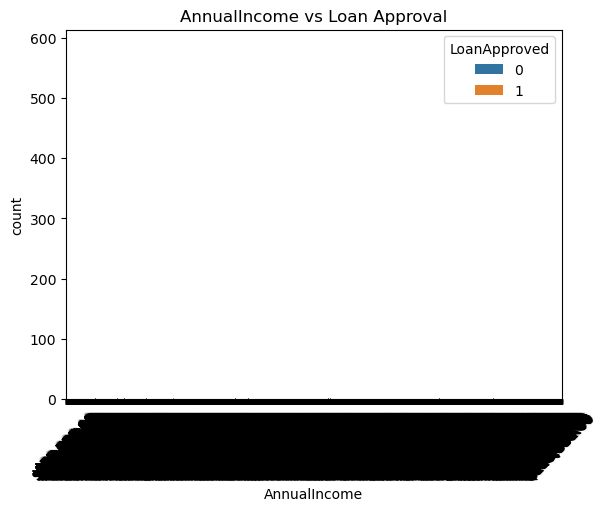

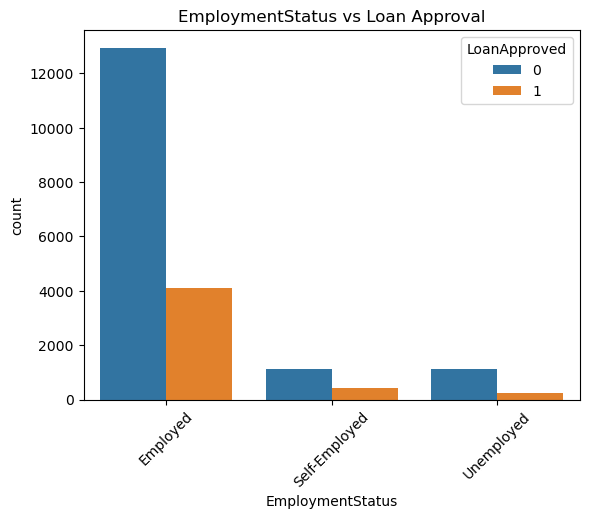

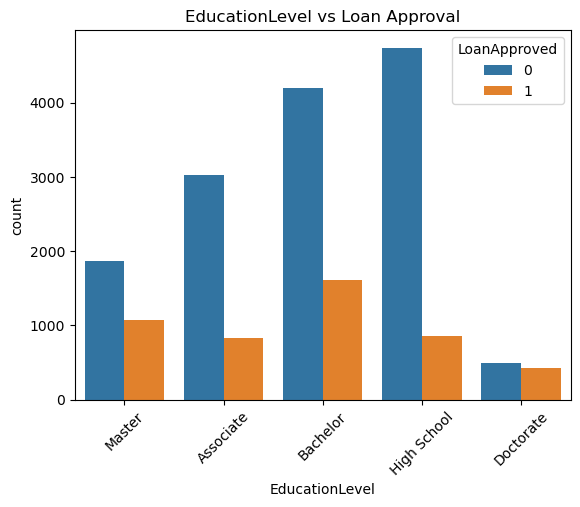

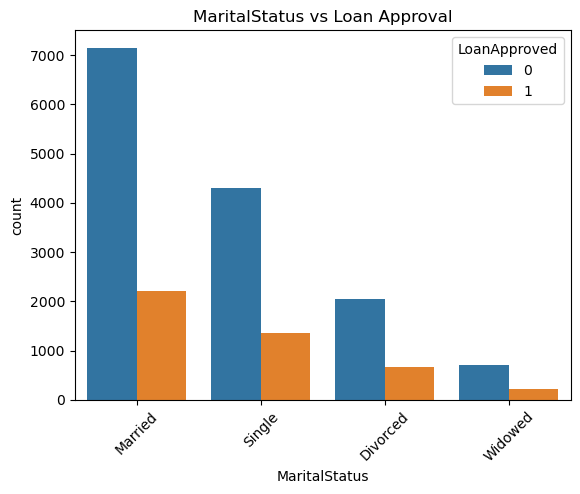

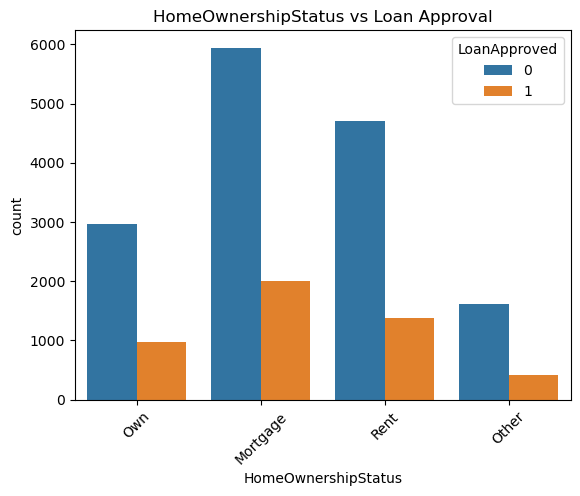

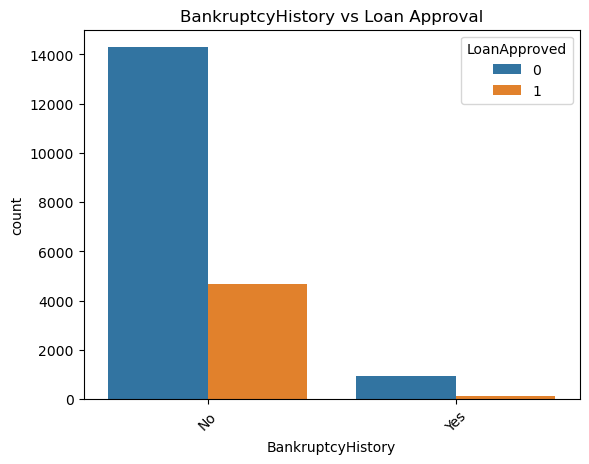

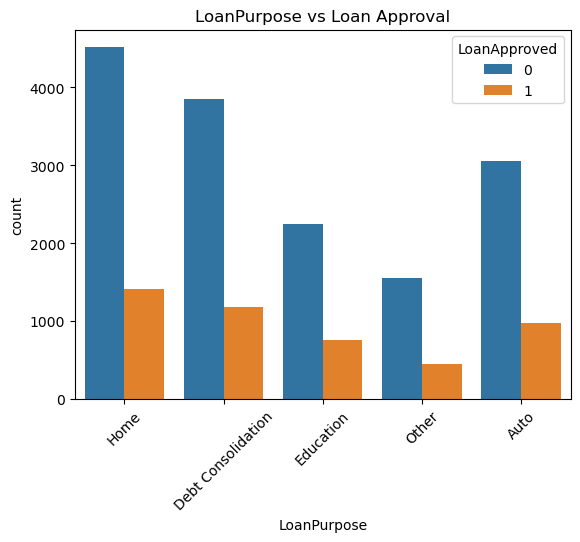

In [11]:
# Categorical feature inspection
cat_cols = data.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    sns.countplot(data=data, x=col, hue='LoanApproved')
    plt.title(f"{col} vs Loan Approval")
    plt.xticks(rotation=45)
    plt.show()

In [12]:
# Define feature groups
target = "LoanApproved"
X = data.drop(columns=["LoanApproved", "RiskScore"])  # RiskScore is target in regression scenario
y = data[target]

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [14]:
# Separate feature types
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [15]:
numeric_features

['Age',
 'CreditScore',
 'Experience',
 'LoanAmount',
 'LoanDuration',
 'NumberOfDependents',
 'MonthlyDebtPayments',
 'CreditCardUtilizationRate',
 'NumberOfOpenCreditLines',
 'NumberOfCreditInquiries',
 'DebtToIncomeRatio',
 'PreviousLoanDefaults',
 'PaymentHistory',
 'LengthOfCreditHistory',
 'SavingsAccountBalance',
 'CheckingAccountBalance',
 'TotalAssets',
 'TotalLiabilities',
 'MonthlyIncome',
 'UtilityBillsPaymentHistory',
 'JobTenure',
 'NetWorth',
 'BaseInterestRate',
 'InterestRate',
 'MonthlyLoanPayment',
 'TotalDebtToIncomeRatio']

In [14]:
categorical_features

['AnnualIncome',
 'EmploymentStatus',
 'EducationLevel',
 'MaritalStatus',
 'HomeOwnershipStatus',
 'BankruptcyHistory',
 'LoanPurpose']

In [16]:
# Create transformer for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing with median
    ('scaler', StandardScaler())  # Scale features to have mean=0, variance=1
])

In [17]:
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [18]:
# Create transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill with most common value
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # One-hot encode
])

In [19]:
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [20]:
# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [21]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'CreditScore', 'Experience',
                                  'LoanAmount', 'LoanDuration',
                                  'NumberOfDependents', 'MonthlyDebtPayments',
                                  'CreditCardUtilizationRate',
                                  'NumberOfOpenCreditLines',
                                  'NumberOfCreditInquiries',
                                  'DebtToIncomeRatio', 'PreviousLoanDe...
                                  'NetWorth', 'BaseInterestRate',
                                  'InterestRate', 'MonthlyLoanPayment',
                                  'TotalDebtToIncomeRatio']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['AnnualIncome', 'EmploymentStatus',
                                  'EducationLevel', 'MaritalStatus',
                                  'HomeOwnershipStatus', 'BankruptcyHistory',
                                  'LoanPurpose'])])

In [22]:
# Define feature groups
target = "LoanApproved"
X = data.drop(columns=["LoanApproved", "RiskScore"])  # RiskScore is target in regression scenario
y = data[target]

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [24]:
# Check shapes as quick sanity check
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (15000, 33)
Test set shape: (5000, 33)


In [32]:
# Create pipelines with different models
# 1. Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [33]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'CreditScore',
                                                   'Experience', 'LoanAmount',
                                                   'LoanDuration',
                                                   'NumberOfDependents',
                                                   'MonthlyDebtPayments',
                                                   'CreditCardUtilizationRate',
                                                   'NumberOfOpenCreditLines',
                                                   'NumberOfCreditInquiries',
                                                   'De...
                                                   'TotalDebtToIncomeRatio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['AnnualIncome',
                                                   'EmploymentStatus',
                                                   'EducationLevel',
                                                   'MaritalStatus',
                                                   'HomeOwnershipStatus',
                                                   'BankruptcyHistory',
                                                   'LoanPurpose'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [34]:
# 2. Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [35]:
lr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'CreditScore',
                                                   'Experience', 'LoanAmount',
                                                   'LoanDuration',
                                                   'NumberOfDependents',
                                                   'MonthlyDebtPayments',
                                                   'CreditCardUtilizationRate',
                                                   'NumberOfOpenCreditLines',
                                                   'NumberOfCreditInquiries',
                                                   'De...
                                                   'TotalDebtToIncomeRatio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['AnnualIncome',
                                                   'EmploymentStatus',
                                                   'EducationLevel',
                                                   'MaritalStatus',
                                                   'HomeOwnershipStatus',
                                                   'BankruptcyHistory',
                                                   'LoanPurpose'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [36]:
# Define parameter grids for each model
rf_param_grid = {
    # Preprocessing parameters
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    
    # Model parameters
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': ['balanced', None]
}

In [37]:
lr_param_grid = {
    # Preprocessing parameters
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    
    # Model parameters
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__class_weight': ['balanced', None],
    'classifier__solver': ['liblinear', 'saga']
}

In [38]:
# Define scoring metrics - we'll track multiple metrics
# but optimize for F1 score 
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

In [41]:
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [42]:
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [43]:
# Fit models
rf_grid_search.fit(X_train, y_train)
lr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'CreditScore',
                                                                          'Experience',
                                                                          'LoanAmount',
                                                                          'LoanDuration',
                                                                          'NumberOfDependents',
                                                                          'MonthlyDebtPayments',
                                                                          'CreditCardUtilizationRate',
                                                                          'NumberOfOpenCreditLines',
                                                                          '...
                                                                          'MaritalStatus',
                                                                          'HomeOwnershipStatus',
                                                                          'BankruptcyHistory',
                                                                          'LoanPurpose'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1.0, 10.0],
                         'classifier__class_weight': ['balanced', None],
                         'classifier__solver': ['liblinear', 'saga'],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']},
             scoring='accuracy')

In [47]:
#Compare the models to select the best one:
# Get best parameters and scores
print("\n===== Grid Search Results =====")
print(f"Best Random Forest Accuracy: {rf_grid_search.best_score_:.4f}")
print(f"Best Logistic Regression Accuracy: {lr_grid_search.best_score_:.4f}")


===== Grid Search Results =====
Best Random Forest Accuracy: 0.9001
Best Logistic Regression Accuracy: 0.9639


In [48]:
# Select the best model based on Accuracy
if rf_grid_search.best_score_ >= lr_grid_search.best_score_:
    best_model = rf_grid_search
    model_name = "Random Forest"
else:
    best_model = lr_grid_search
    model_name = "Logistic Regression"

print(f"\nBest model: {model_name}")
print("Best parameters:")
for param, value in best_model.best_params_.items():
    print(f"  {param}: {value}")


Best model: Logistic Regression
Best parameters:
  classifier__C: 10.0
  classifier__class_weight: None
  classifier__solver: liblinear
  preprocessor__num__imputer__strategy: mean


In [52]:
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



===== Final Model Evaluation =====
Test set Accuracy: 0.9650

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3805
           1       0.93      0.92      0.93      1195

    accuracy                           0.96      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.96      0.96      0.96      5000



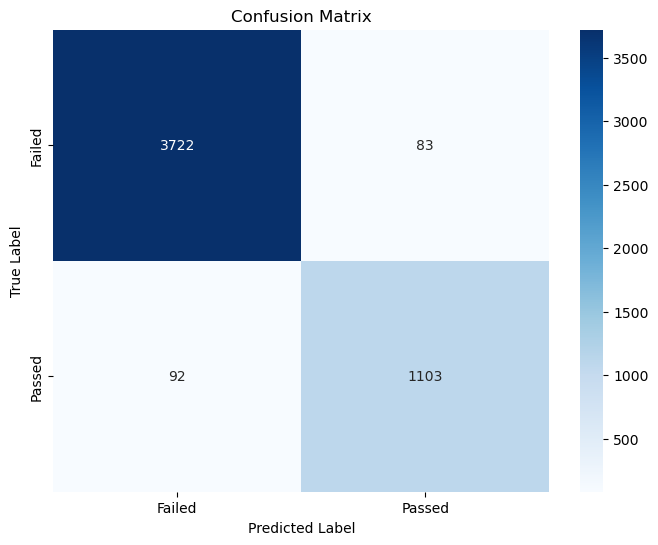

In [53]:
# Get the best model
final_model = best_model.best_estimator_

# Make predictions on test set
y_pred = final_model.predict(X_test)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n===== Final Model Evaluation =====")
print(f"Test set Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Failed', 'Passed'])
plt.yticks([0.5, 1.5], ['Failed', 'Passed'])
plt.show()

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

In [58]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
print("ROC AUC:", roc_auc_score(y_test, y_proba))

ROC AUC: 0.9943393134996343


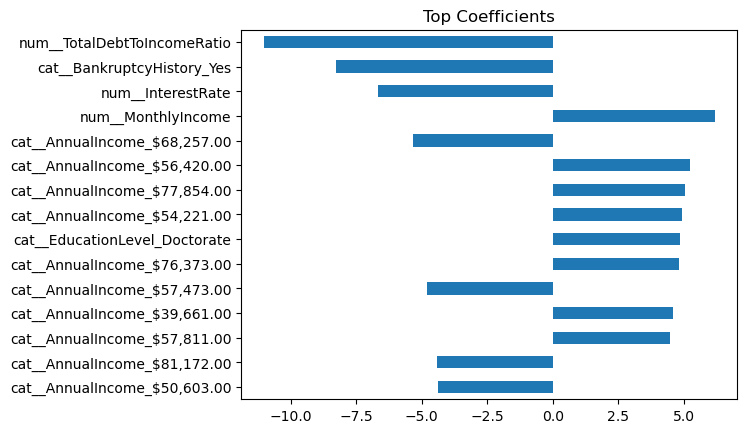

In [61]:
# For Random Forest
if isinstance(best_model.best_estimator_.named_steps['classifier'], RandomForestClassifier):
    importances = best_model.best_estimator_.named_steps['classifier'].feature_importances_
    feature_names = best_model.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    feat_imp.head(15).plot(kind='barh', title="Top Feature Importances")
    plt.gca().invert_yaxis()
    plt.show()

# For Logistic Regression
elif isinstance(best_model.best_estimator_.named_steps['classifier'], LogisticRegression):
    coefs = best_model.best_estimator_.named_steps['classifier'].coef_[0]
    feature_names = best_model.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    coef_df = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)
    coef_df.head(15).plot(kind='barh', title="Top Coefficients")
    plt.gca().invert_yaxis()
    plt.show()

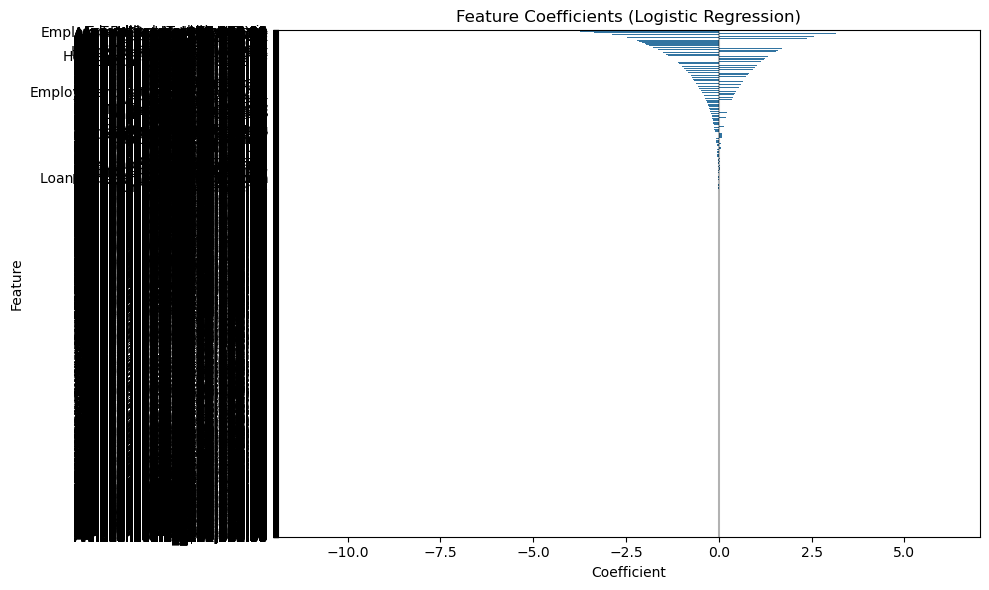


Top 5 features with largest coefficients (absolute value):
                       Feature  Coefficient
25      TotalDebtToIncomeRatio   -11.016852
13526    BankruptcyHistory_Yes    -8.276041
23                InterestRate    -6.682739
18               MonthlyIncome     6.175913
11071  AnnualIncome_$68,257.00    -5.332240

===== Model Summary =====
Selected model: Logistic Regression
Business goal: Enhance or automate the loan approval process using historical loan data
Primary metric: Accuracy, Since False Approvals are Costly
Test set performance: 0.9650 accuracy

Key preprocessing decisions:
  Numeric features imputation strategy: mean
  Categorical features handled with one-hot encoding
  All numeric features standardized to mean=0, variance=1

Model successfully trained and evaluated!


In [62]:
# Analyze feature importance or coefficients based on model type
if model_name == "Random Forest":
    # Get the Random Forest model from the pipeline
    rf_model = final_model.named_steps['classifier']
    
    # Get feature names after preprocessing
    preprocessor = final_model.named_steps['preprocessor']
    
    # Get feature names
    feature_names = []
    feature_names.extend(numeric_features)
    
    # For categorical features, get the encoded feature names
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
    encoded_cat_features = cat_encoder.get_feature_names_out(categorical_features)
    feature_names.extend(encoded_cat_features)
    
    # Get feature importances
    importances = rf_model.feature_importances_
    
    # Sort features by importance
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_imp = feature_imp.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp)
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 most important features:")
    print(feature_imp.head(5))
else:
    # For Logistic Regression, examine coefficients
    lr_model = final_model.named_steps['classifier']

    # Get feature names after preprocessing
    preprocessor = final_model.named_steps['preprocessor']
    
    # Get feature names using same approach
    feature_names = []
    feature_names.extend(numeric_features)
    
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
    encoded_cat_features = cat_encoder.get_feature_names_out(categorical_features)
    feature_names.extend(encoded_cat_features)
    
    # Get coefficients
    coefficients = lr_model.coef_[0]
    
    # Create DataFrame of coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)
    
    # Plot coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title('Feature Coefficients (Logistic Regression)')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 features with largest coefficients (absolute value):")
    print(coef_df.head(5))

# Summarize modeling decisions
print("\n===== Model Summary =====")
print(f"Selected model: {model_name}")
print("Business goal: Enhance or automate the loan approval process using historical loan data")
print("Primary metric: Accuracy, Since False Approvals are Costly")
print(f"Test set performance: {test_accuracy:.4f} accuracy")
print("\nKey preprocessing decisions:")
print(f"  Numeric features imputation strategy: {best_model.best_params_.get('preprocessor__num__imputer__strategy', 'Not specified')}")
print("  Categorical features handled with one-hot encoding")
print("  All numeric features standardized to mean=0, variance=1")

print("\nModel successfully trained and evaluated!")